In [22]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available: 0


In [23]:
with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"].values
X_val   = data["X_val"].values
X_test  = data["X_test"].values
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]
test_dates = data["test_dates"]
scaler  = data["scaler"]
#this was named yscaler initially (without "_"); watch out!
y_scaler = data["scaler_y"]

print(data.keys())

y_test.shape

dict_keys(['X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test', 'scaler', 'scaler_y', 'test_dates'])


(213661, 1)

In [24]:
sequence_length = 5

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, sequence_length)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, sequence_length)


print(X_train_seq.min(), X_train_seq.max(), X_train_seq.std())
print(y_train_seq.min(), y_train_seq.max(), y_train_seq.std())


0.0 1.0000000000000002 0.22992918157100303
0.0 1.0 0.2056241659137077


In [25]:


'''model = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    LSTM(64),
    Dense(1)
])'''
model = Sequential([
    Input(shape=(sequence_length, X_train_seq.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.2), # Dropout layer for regularization
    LSTM(64),
    Dropout(0.2), # Dropout layer before the output (optional, but good)
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [26]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

class PredictionHistory(Callback):
    def __init__(self, X_train_seq, y_train_seq, y_scaler):
        super().__init__()
        self.X_train_seq = X_train_seq
        self.y_train_seq = y_train_seq
        self.y_scaler = y_scaler
        self.predictions_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict on the training set
        pred_scaled = self.model.predict(self.X_train_seq, verbose=0)
        pred_inv = self.y_scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()
        self.predictions_per_epoch.append(pred_inv)

        # Compute RMSE for monitoring
        actual = self.y_scaler.inverse_transform(self.y_train_seq.reshape(-1,1)).flatten()
        rmse = np.sqrt(np.mean((actual - pred_inv)**2))
        print(f"Epoch {epoch+1} - Train RMSE: {rmse:.4f}")


Epoch 1/10
31155/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249Epoch 1 - Train RMSE: 0.9032
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 401s 13ms/step - loss: 0.0221 - val_loss: 0.0377
Epoch 2/10
31158/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0192Epoch 2 - Train RMSE: 0.8960
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 406s 13ms/step - loss: 0.0186 - val_loss: 0.0373
Epoch 3/10
31156/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176Epoch 3 - Train RMSE: 0.8984
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 415s 13ms/step - loss: 0.0171 - val_loss: 0.0377
Epoch 4/10
31157/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165Epoch 4 - Train RMSE: 0.8846
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 412s 13ms/step - loss: 0.0161 - val_loss: 0.0367
Epoch 5/10
31154/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156Epoch 5 - Train RMSE: 0.8661
31159/31159 ━━━━━━━━━━━━━━━━━━━━ 422s 14ms/step - loss: 0.0152 - val_loss: 0.0353
Epoch 6/10
31156/31159 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148Epoch 6 - Train RMSE: 0.8

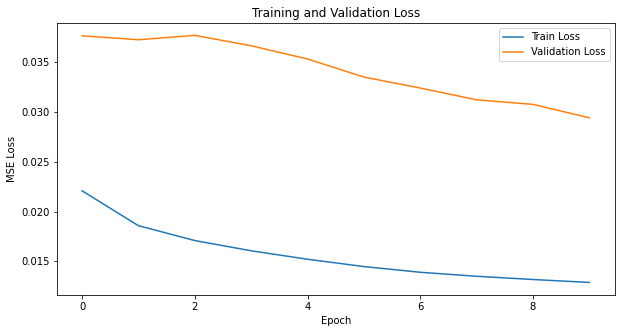

In [27]:

callback = PredictionHistory(X_train_seq, y_train_seq, y_scaler)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,#2 previously
    batch_size=32,
    shuffle=False,
    callbacks=[callback]
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


/home/daniel/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


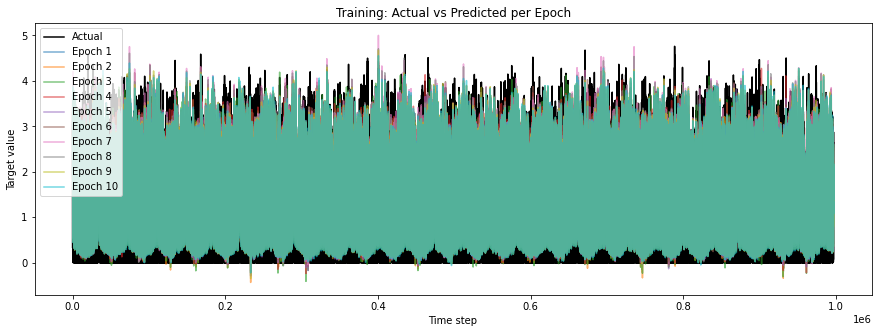

In [28]:
actual = y_scaler.inverse_transform(y_train_seq.reshape(-1,1)).flatten()

plt.figure(figsize=(15,5))
plt.plot(actual, label="Actual", color='black')

# Plot predictions for each epoch
for i, pred in enumerate(callback.predictions_per_epoch):
    plt.plot(pred, label=f"Epoch {i+1}", alpha=0.6)

plt.xlabel("Time step")
plt.ylabel("Target value")
plt.title("Training: Actual vs Predicted per Epoch")
plt.legend()
plt.show()


In [29]:
pred_scaled = model.predict(X_test_seq)

print(pred_scaled)
print(X_test_seq)
# Inverse scale both prediction and ground truth
pred = y_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
print(actual.min(), actual.max(), actual.std())

# Compute RMSE
rmse = np.sqrt(np.mean((actual - pred)**2))
print(f"RMSE: {rmse:.4f}")

6677/6677 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step
[[0.06723867]
 [0.07055241]
 [0.06937906]
 ...
 [0.22189513]
 [0.18267009]
 [0.20548522]]
[[[0.51757188 0.45529801 0.43066884 ... 0.36170213 0.37837838 0.29832936]
  [0.50638978 0.46688742 0.43882545 ... 0.46808511 0.43243243 0.30310263]
  [0.5543131  0.51821192 0.49918434 ... 0.53191489 0.43243243 0.31264916]
  [0.49680511 0.4718543  0.46655791 ... 0.38297872 0.35135135 0.31742243]
  [0.54632588 0.52980132 0.51712887 ... 0.5106383  0.43243243 0.33293556]]

 [[0.50638978 0.46688742 0.43882545 ... 0.46808511 0.43243243 0.30310263]
  [0.5543131  0.51821192 0.49918434 ... 0.53191489 0.43243243 0.31264916]
  [0.49680511 0.4718543  0.46655791 ... 0.38297872 0.35135135 0.31742243]
  [0.54632588 0.52980132 0.51712887 ... 0.5106383  0.43243243 0.33293556]
  [0.59105431 0.56622517 0.57096248 ... 0.53191489 0.43243243 0.33770883]]

 [[0.5543131  0.51821192 0.49918434 ... 0.53191489 0.43243243 0.31264916]
  [0.49680511 0.4718543  0.46655791 ... 0.382978

[0.320185   0.33596474 0.33037737 ... 1.0566463  0.8698599  0.9785037 ]


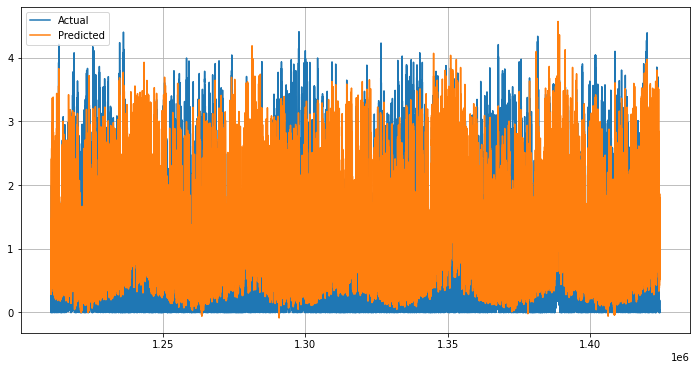

In [30]:
print(pred)
plt.figure(figsize=(12, 6))
plt.plot(test_dates[sequence_length:], actual, label='Actual')
plt.plot(test_dates[sequence_length:], pred, label='Predicted')
plt.legend()
plt.grid(True)
plt.show()

